In [1]:
import logging, os
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import datetime
from pathlib import Path

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf

from tqdm.notebook import tqdm

from concurrent.futures import ThreadPoolExecutor

from importlib import reload
import keras_model_creator
import sentinel_utils
import plot_utils
import ee_downloader
from data_generator import DataGenerator

In [2]:
reload(sentinel_utils)

model_dir = Path('models', 'selected_model')
shards_dir = Path('/mnt', 'wsl', 'training_data', 'shards', 'old')

min_occurrences = 20000
utils = sentinel_utils.SentinelUtils(
    min_occurrences=min_occurrences,
    shards_dir=shards_dir
)

selected_classes = utils.get_processed_labels()

training_years = '2017_2018_2019'
data_summary = utils.get_data_summary(
    selected_classes, training_years=training_years,
    overwrite_existing=False
)

batch_size = 64

model_parent_dir = Path('models')
model_dir = model_parent_dir.joinpath(
    f'hypertuned-{len(selected_classes.index)}'
    f'-{selected_classes.shape[1]}-{batch_size}'
    f'-{training_years}'
)
model_dir.mkdir(parents=True, exist_ok=True)

params = dict(
    selected_classes=selected_classes,
    data_summary=data_summary,
    model_dir=model_dir,
    batch_size=batch_size,
    years=training_years,
    epochs=100,
    overwrite=False,
    verbose=1,
    shards_dir=shards_dir,
    print_log=0,    
)
model_dir

PosixPath('models/hypertuned-237212-7-64-2017_2018_2019')

In [3]:
reload(keras_model_creator)
model, testing_generator = keras_model_creator.KerasModelCreator(**params).run()

In [4]:
y_true = selected_classes.to_numpy()

weather_median = pd.read_csv(Path('weather_data', 'era5_2017.csv'))
weather_median = weather_median.interpolate(method='nearest').ffill().bfill()

eval_years = list(range(2020, 2025))
corrs = []

weathers = []
weather_diffs = []
y_diffs = []

for eval_year in tqdm(eval_years):
    eval_generator = DataGenerator(
        selected_classes.index, shuffle=False, year=eval_year, **params
    )
    preds_path = model_dir.joinpath(f'preds_{eval_year}.npy')
    if preds_path.is_file():
        y_pred = np.load(preds_path)
    else:
        y_pred = model.predict(x=eval_generator, verbose=1)
        np.save(preds_path, y_pred)

    weather = pd.read_csv(Path('weather_data', f'era5_{eval_year}.csv'))
    weather = weather.interpolate(method='nearest').ffill().bfill()

    y_diff = pd.DataFrame(
        y_pred - y_true[:y_pred.shape[0]], 
        columns=selected_classes.columns
    )
    weather_diff = (
        (weather - weather_median)
        .loc[selected_classes.index]
        .iloc[:y_pred.shape[0]]
    )

    weather_diffs.append(weather_diff)
    
    y_diffs.append(y_diff)
    
    corr = pd.concat(
        [y_diff, weather_diff], axis=1, keys=['df1', 'df2']
    ).corr().loc['df2', 'df1'].round(2)
    corrs.append(corr)

    weather['year'] = eval_year
    weathers.append(weather)

  0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
weathers_df = pd.concat(weathers)

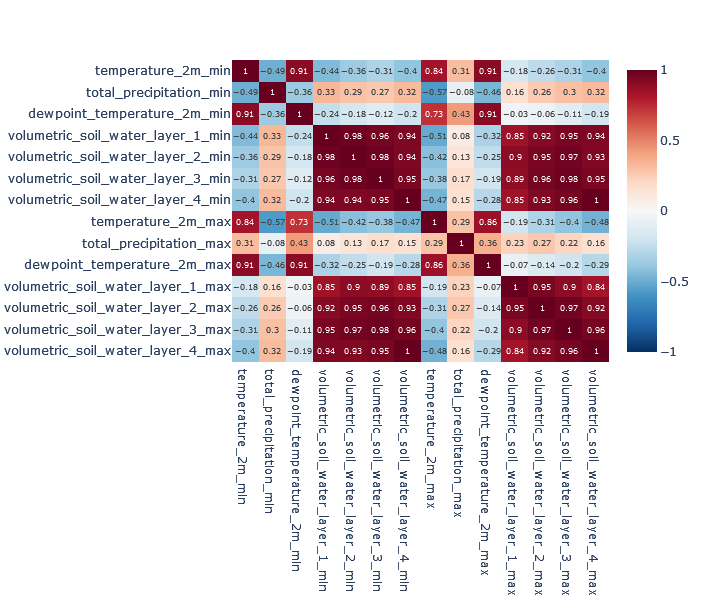

In [22]:
px.imshow(
    weathers_df.drop('year', axis=1).corr().round(2),
    text_auto=True, aspect='auto', zmin=-1, zmax=1,
    color_continuous_scale='RdBu_r',
    height=600,
)

{'row': 1, 'col': 1}
{'row': 1, 'col': 2}
{'row': 2, 'col': 1}
{'row': 2, 'col': 2}
{'row': 3, 'col': 1}
{'row': 3, 'col': 2}
{'row': 4, 'col': 1}


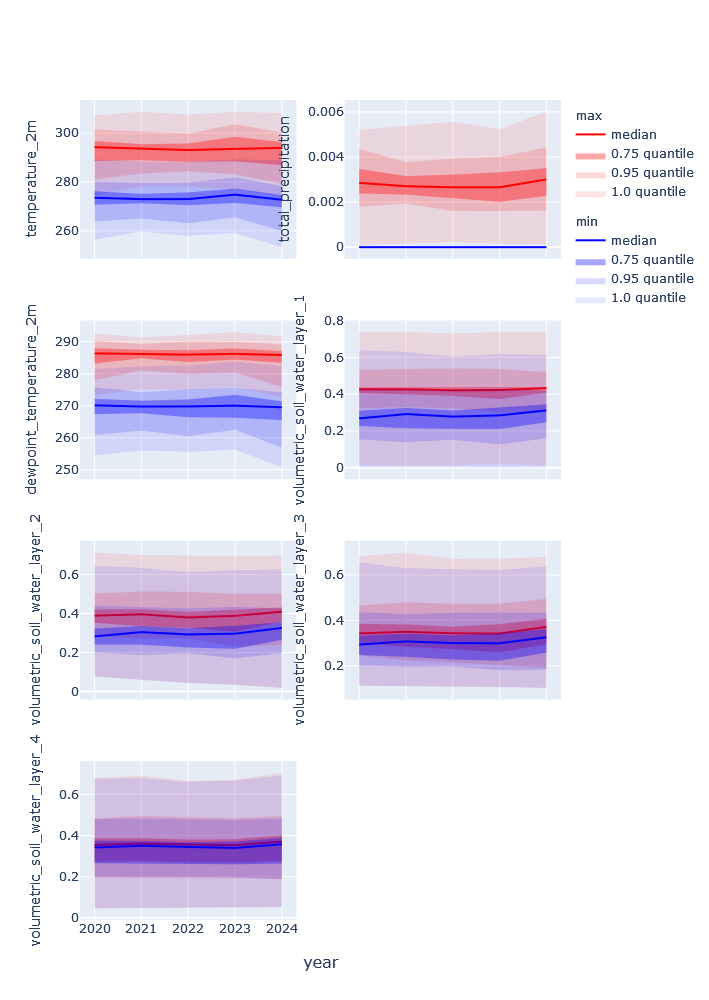

In [11]:
variables = (
    weathers_df
    .drop('year', axis=1)
    .columns.str.split('_').str[:-1].str.join('_')
    .unique()
)

nrows, ncols = 4, 2
fig = make_subplots(
    rows=nrows, cols=ncols,
    shared_xaxes='all',
    x_title='year',
    # shared_yaxes='rows',
    # y_title=variable,
    # subplot_titles=trials_df.columns[1:].str.replace('_', '<br>'),
    # vertical_spacing=0.3,
    horizontal_spacing=0.1
)

yearly_weather = weathers_df.groupby('year')
x = weathers_df['year'].unique().tolist()

for i, variable in enumerate(variables):
    position = dict(row=(i//ncols)+1, col=(i%ncols)+1)
    for color, minmax in zip(['red', 'blue'], ['max', 'min']):
        median = yearly_weather[f'{variable}_{minmax}'].agg('median')
        fig.add_trace(go.Scatter(
            x=x,
            y=median,
            line_color=color,
            mode='lines',
            legendgroup=minmax,
            legendgrouptitle_text=minmax,
            name='median',
            showlegend=True if i == 0 else False
        ), **position)
        for quantile in [0.75, 0.95, 1.0]:
            upper_quantile = yearly_weather[f'{variable}_{minmax}'].quantile(quantile)
            lower_quantile = yearly_weather[f'{variable}_{minmax}'].quantile(1-quantile)
            fig.add_trace(go.Scatter(
                x=x+x[::-1],
                y=pd.concat([upper_quantile, lower_quantile[::-1]]),
                fill='toself',
                fillcolor=color,
                opacity=1.1-quantile,
                line_color='rgba(255,255,255,0)',
                hoverinfo='skip',
                legendgroup=minmax,
                name=f'{quantile} quantile',
                showlegend=True if i == 0 else False
            ), **position)
    fig.update_yaxes(title=variable, **position)
    # fig.update_xaxes(title='year')

fig.update_layout(height=1000)
fig.show()

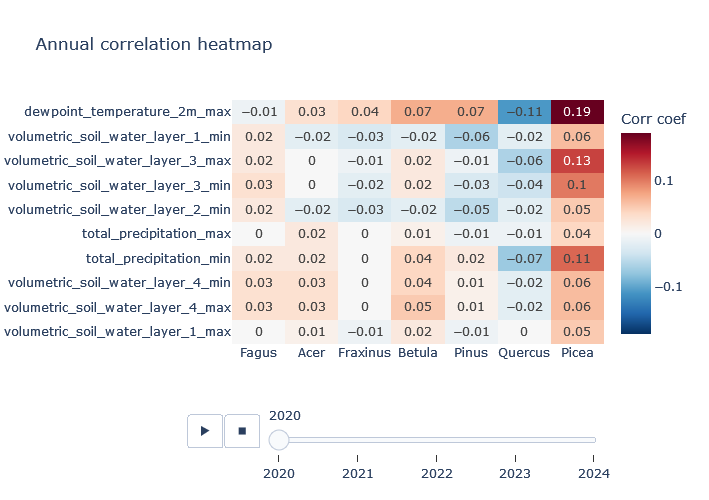

In [12]:
top_genus = pd.concat(corrs).abs().agg('max').sort_values().index[:14].tolist()
top_climate = pd.concat(corrs).T.abs().agg('max').sort_values().index[:14].tolist()

zmax = max([corr.abs().max().max() for corr in corrs])
fig = px.imshow(
    np.array([corr[top_genus].loc[top_climate] for corr in corrs]),
    animation_frame=0,
    labels=dict(color="Corr coef"),
    x=top_genus,
    y=top_climate,
    title='Annual correlation heatmap',
    color_continuous_scale='RdBu_r',
    text_auto=True, aspect='auto', 
    zmin=-zmax, 
    zmax=zmax, 
    height=500
)
fig.layout.sliders[0]['currentvalue']['prefix'] = ''
for year, step in zip(eval_years, fig.layout.sliders[0].steps):
    step.label = str(year)
fig

In [13]:
from tensorflow.keras.layers import *
from sklearn.preprocessing import StandardScaler

r2_scores_path = Path('tmp', f'r2_scores_{min_occurrences}_{training_years}.csv')

if r2_scores_path.is_file():
    r2_scores = pd.read_csv(r2_scores_path, index_col=[0])
else:
    x_input = Input((weather_diff.shape[-1],))
    
    for units in [128, 64]:
        x = Dense(units, activation='relu')(x_input)
    x = Dropout(0.2)(x)
    outputs = Dense(y_diffs[0].shape[-1], activation='sigmoid')(x)
    
    all_scores = []
    for weather_diff, y_diff in tqdm(list(zip(weather_diffs, y_diffs))):
        scores = []
        for genus in tqdm(y_diff.columns, leave=False):
            m = tf.keras.models.Model(inputs=[x_input], outputs=outputs)
            m.compile(optimizer='adam', loss='huber', 
                      metrics=['root_mean_squared_error', 'r2_score'])
            hist = m.fit(
                x=StandardScaler().fit_transform(weather_diff), 
                y=y_diff[[genus]],
                validation_split=0.1,
                epochs=10, verbose=0
            )
            scores.append(hist.history['val_r2_score'][-1])
        all_scores.append(scores)
            
    r2_scores = pd.DataFrame(
        all_scores, columns=y_diff.columns.tolist(), index=eval_years
    )
    r2_scores.to_csv(r2_scores_path)

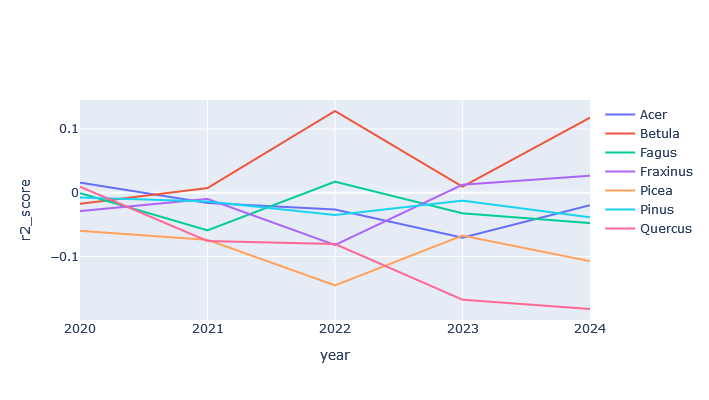

In [14]:
high_r2 = r2_scores#.T[(r2_scores.mean() > 0.2).values].T
fig = go.Figure()
for col in high_r2.columns:
    fig.add_trace(go.Scatter(
        x=high_r2.index, y=high_r2[col], name=col, mode='lines'))
fig.update_layout(yaxis_title='r2_score', xaxis_title='year', height=400)